<a href="https://colab.research.google.com/github/PyThaiNLP/thaimaimeex/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict `log_budget` from `thaimaimeex` Dataset

We tried using `project_name` of ThaiME projects to predict how much `log_budget` they will get. The benchmark is done among LinearSVR, ULMFit and Multilingual Universal Sentence Encoder + LinearSVR. The metric is mean squared error (MSE).

| models       | mse      |
|--------------|----------|
| predict mean | 2.455477 |
| **LinearSVR**    | **1.166351** |
| ULMFit       | 1.170797 |
| USE          | 1.749290 |

In [1]:
#download and installs for colab
!npx degit pythainlp/thaimaimeex -f
!pip install emoji
!pip install pythainlp -q
!pip install tensorflow_text

npx: installed 1 in 2.988s
> destination directory is not empty. Using --force, continuing
> cloned pythainlp/thaimaimeex#master
     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=3219fb8543ab538b558ca4affe3c69930a690fe7a421c804b0290b1139cb1e17
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 11.1MB 279kB/s 
     |████████████████████████████████| 1.4MB 48.9MB/s 
     |████████████████████████████████| 3.0MB 9.4MB/s 


In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import re
from sklearn.metrics import f1_score,precision_score,recall_score
from pythainlp.tokenize import word_tokenize
from pythainlp.ulmfit import *

y = 'log_budget'

import warnings
warnings.filterwarnings('ignore')

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:37<00:00, 27787922.91it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 62675159.27it/s]


In [0]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
from plotnine import *
from mizani import *
import matplotlib.pyplot as plt
import seaborn as sns
theme_set(theme_minimal(14, 'TH Sarabun New'))

# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

In [0]:
#handle version difference
try:
  THWIKI_LSTM =_THWIKI_LSTM
except:
  THWIKI_LSTM = THWIKI_LSTM

In [5]:
thaime = pd.read_csv('data/thaimaimeex.csv')
thaime.columns = ['texts', 'unit', 'ministry', 'log_budget', 'test_flag']
train_df = thaime[thaime.test_flag==0]
test_df = thaime[thaime.test_flag==1]
X_train, y_train = train_df['texts'], train_df[y]
X_test, y_test = test_df['texts'], test_df[y]
thaime.shape,train_df.shape,test_df.shape

((31501, 5), (26776, 5), (4725, 5))

## Linear SVR

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2))),
    ('clf', SVR(kernel='linear')),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function process_thai at 0x7f8b3ba61ea0>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scal

In [0]:
pred = text_clf.predict(X_test)
np.mean((pred-y_test)**2), np.mean((y_test-y_test.mean())**2),\
np.mean((np.exp(pred)-np.exp(y_test))**2), np.mean((np.exp(y_test)-np.exp(y_test.mean()))**2),

(1.1663506493608127,
 2.4554771615351085,
 1.4494448478124762e+16,
 1.4623253764252518e+16)

(array([  20.,  198., 1226., 1023., 1011.,  700.,  414.,  108.,   22.,
           3.]),
 array([11.03361369, 11.80963257, 12.58565145, 13.36167033, 14.13768921,
        14.91370809, 15.68972697, 16.46574585, 17.24176473, 18.01778361,
        18.79380249]),
 <a list of 10 Patch objects>)

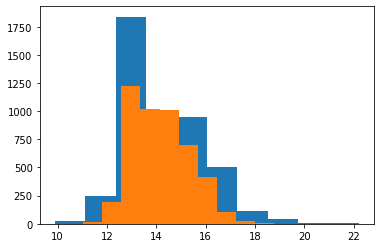

In [0]:
plt.hist(y_test)
plt.hist(pred)

## ULMFit

In [0]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback

from pythainlp.ulmfit import *

model_path = 'models/'
!mkdir models

In [7]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(thaime, model_path, cols=['texts'], processor=processor)
    .random_split_by_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=64))
data_lm.sanity_check()
data_lm.save('thaime_lm.pkl')

In [8]:
data_lm = load_data(model_path,'thaime_lm.pkl')
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(31186, 315)

In [9]:
data_lm.show_batch(5)

idx,text
0,หาด อำเภอ คลอง หาด จังหวัด สระ แก้ว xxbos - ก่อสร้าง ระบบ ประปา หมู่บ้าน พร้อม เจาะ บ่อ บาดาล หมู่ ที่ 13 บ้าน คลอง หาด พัฒนา ( กลุ่ม บ้าน ผู้ช่วย ไก่ ) เทศบาลตำบล คลอง หาด อำเภอ คลอง หาด จังหวัด สระ แก้ว xxbos - ก่อสร้าง ระบบ ประปา หมู่บ้าน พร้อม เจาะ บ่อ
1,อ. เชียง กลาง จ. น่าน xxbos 26. ก่อสร้าง ธนาคาร น้ำใต้ดิน ระบบ เปิด จุด ที่ 2 บ้าน หนอง ปลิง หมู่ ที่ 7 ตำบล ทุ่ง กระ บ่ำ xxbos 26. ก่อสร้าง ฝายน้ำล้น ( จุด นาย ไพฑูรย์ - นาย เร วิ xxunk บ้าน เขา น้อย
2,การ สร้าง งาน สร้าง อาชีพ และ เพิ่ม ช่องทาง สร้าง ราย ได้แก่ ประชาชน ผู้ ว่างงาน ใน จังหวัด สุพรรณบุรี ( กิจกรรม ส่งเสริม รับ งาน ไป ทำ ที่ บ้าน ) xxbos การ สร้าง งาน สร้าง อาชีพ และ เพิ่ม ช่องทาง สร้าง ราย ได้แก่ ประชาชน ผู้ ว่างงาน ใน จังหวัด สุพรรณบุรี ( กิจกรรม แปรรูป เกษตร อินทรีย์ ) xxbos การ สร้าง
3,สาย คัน คลอง แม่น้ำ ยม สาย เก่า xxbos ก่อสร้าง ถนน คส ล. สาย จาก หมู่ ที่ 4 บ้าน หัว เขา นาค ไป ถึง หมู่ ที่ 3 ตำบล เขา ขี้ ฝอย xxbos ก่อสร้าง ถนน คส ล. สาย จาก คลอง ชลประทาน lmc ถึง โรงเรียน
4,หนา 0.15 เมตร หรือ มี พื้นที่ ไม่ น้อยกว่า 760.00 ตารางเมตร เทศบาลตำบล งิ ม อำเภอ ปง จัว หวัด พะเยา xxbos ก่อสร้าง ถนน คส ล. เข้าสู่ พื้นที่ การเกษตร บ้าน แบ่ง หมู่ ที่ 5 ปริมาณ งาน ก่อสร้าง ถนน คส


In [10]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (31186 items)
x: LMTextList
xxbos   " มะนาว พา สุข "   เพิ่ม คุณภาพชีวิต คนพิการ ใน จังหวัด สิงห์บุรี,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน   แบบ บาดาล ขนาด กลาง   บริเวณ จุดชมวิว   หมู่ ที่   9   บ้าน เขา เลื่อม ใต้,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน   แบบ ผิว ดิน ขนาด กลาง   หมู่ ที่   1   บ้าน คลอง หาด   เทศบาลตำบล คลอง หาด   อำเภอ คลอง หาด   จังหวัด สระ แก้ว,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน พร้อม เจาะ บ่อ บาดาล   หมู่ ที่   10   บ้าน ไทย พัฒนา   ( กลุ่ม ตา xxunk )   เทศบาลตำบล คลอง หาด   อำเภอ คลอง หาด   จังหวัด สระ แก้ว,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน พร้อม เจาะ บ่อ บาดาล   หมู่ ที่   11   บ้าน ป่า ตะแบก   ( กลุ่ม ตา สอย )   เทศบาลตำบล คลอง หาด   อำเภอ คลอง หาด   จังหวัด สระ แก้ว
y: LMLabelList
,,,,
Path: models;

Valid: LabelList (315 items)
x: LMTextList
xxbos   โครง การพัฒนา เส้นทาง การขนส่ง ผลผลิต ทาง การเกษตร และ เชื่อมโยง การท่องเที่ยว   บ้าน หนอง ฟ้า เลื่อน   หมู่ ที่   5   ตำบล แจ น แลน   อำเภอ กุ ฉิ

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


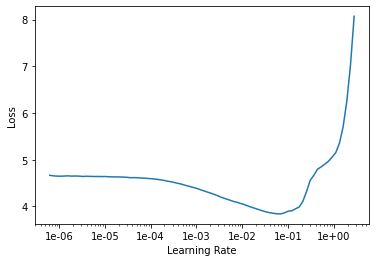

In [0]:
learn.lr_find()
learn.recorder.plot()

In [11]:
len(learn.data.vocab.itos)

8640

In [12]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time
0,3.632674,3.327409,0.438616,00:48


In [13]:
#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,3.227063,2.949345,0.474851,01:05
1,2.896918,2.684199,0.509598,01:05
2,2.699072,2.505657,0.533482,01:05
3,2.556507,2.393703,0.549628,01:05
4,2.476692,2.314165,0.559598,01:05
5,2.398444,2.260101,0.567634,01:05
6,2.379270,2.231065,0.571280,01:05
7,2.337407,2.213618,0.574256,01:05
8,2.330285,2.204820,0.576042,01:05
9,2.328127,2.202490,0.576190,01:05


In [0]:
learn.save('thaime_lm')
learn.save_encoder('thaime_enc')

In [15]:
#test
learn.load('thaime_lm')
for i in range(20):
    print(learn.predict('โครงการ', 20, temperature=0.8, min_p=0.005, sep = ''))

โครงการขุดลอกหนองนาบอน หมู่ที่ 3 บ้านห้วยน้ำใส ต.นาขาม 
โครงการก่อสร้างถนน คสล. สายบ้านนาคำ ม.3 - บ้านนา หมู่
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็กสายบ้านคำฮี หมู่ที่ 12 ตำบลป่าคา ตำบลนาปู่
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็ก สายบ้านดงยาว-บ้านห้วยยาง หมู่ที่ 7 ต.กุด
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็ก สายบ้านนายทวี ทอง ถึงพื้นที่ดำเนินการ หมู่ที่ 7 
โครงการขุดลอกสระน้ำ หมู่ที่ 1 บ้านโนนสามัคคี / (โครงการขุดลอกใหม่
โครงการขุดเจาะบ่อบาดาลเพื่ออุปโภคบริโภคและการเกษตร บ้านหนองบัว หมู่ที่ 8 จุดที่
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็ก สายบ้านม่วง บ้านวังเจริญ หมู่ที่ 6 ตำบลวังหิน
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็ก ถนนสายบ้านทุ่งตา หมู่ที่ 2 - บ้านหนองปลา
โครงการเสริมผิวทางแอสฟัลท์ติกคอนกรีต สายบ้านทุ่งใหม่-บ้านบ่อนา 
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็ก สายบ้านคลองนาน้อย - หมู่ที่ 8xxbos ก่อสร้างถนน
โครงการก่อสร้างถนนคอนกรีตเสริมเหล็กเพื่อการเกษตร สายบ้านหนองปลาน้อย หมู่ที่ 1 ตำบลน้ำอ้อม
โครงการขุดเจาะบ่อบาดาลเพื่ออุปโภคบริโภคและการเกษตร บ้านหนองบัว หมู่ที่ 7 จุดที่
โครงการ ก่อสร้างถนนคอนกรีตเส

In [47]:
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=2)]

data_cls = (TextList.from_df(train_df, model_path, cols=['texts'], processor=processor)
    .random_split_by_pct(valid_pct = 0.05, seed = 1412)
    .label_from_df(y)
    .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
    .databunch(bs=64)
    )

data_cls.sanity_check()
# data_cls.save('thaime_cls.pkl')

In [48]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1)

learn_cls = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn_cls.opt_func = partial(optim.Adam, betas=(0.7, 0.99))

#load pretrained finetuned model
learn_cls.load_encoder('thaime_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25438 items)
x: TextList
xxbos   " มะนาว พา สุข "   เพิ่ม คุณภาพชีวิต คนพิการ ใน จังหวัด สิงห์บุรี,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน   แบบ บาดาล ขนาด กลาง   บริเวณ จุดชมวิว   หมู่ ที่   9   บ้าน เขา เลื่อม ใต้,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน   แบบ ผิว ดิน ขนาด กลาง   หมู่ ที่   1   บ้าน คลอง หาด   เทศบาลตำบล คลอง หาด   อำเภอ คลอง หาด   จังหวัด สระ แก้ว,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน พร้อม เจาะ บ่อ บาดาล   หมู่ ที่   11   บ้าน ป่า ตะแบก   ( กลุ่ม ตา สอย )   เทศบาลตำบล คลอง หาด   อำเภอ คลอง หาด   จังหวัด สระ แก้ว,xxbos   - ก่อสร้าง ระบบ ประปา หมู่บ้าน พร้อม เจาะ บ่อ บาดาล   หมู่ ที่   13   บ้าน คลอง หาด พัฒนา   ( กลุ่ม บ้าน ผู้ช่วย ไก่ )   เทศบาลตำบล คลอง หาด   อำเภอ คลอง หาด   จังหวัด สระ แก้ว
y: FloatList
14.926842,13.165422,14.437161,13.120361,13.120361
Path: models;

Valid: LabelList (1338 items)
x: TextList
xxbos   ก่อสร้าง ฝาย ชะลอ น้ำ กึ่ง ถาวร ดาด ด้วย คอนกรีตเสริมเหล็ก   จุด ที่   80   เพื่อ ป้องกัน และ บร

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


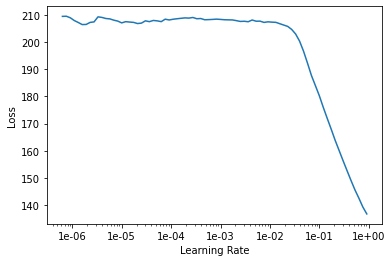

In [31]:
learn_cls.lr_find()
learn_cls.recorder.plot()

In [49]:
#train unfrozen
learn_cls.freeze_to(-1)
learn_cls.fit_one_cycle(2, 1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,time
0,2.911773,2.103544,00:23
1,2.159261,1.517180,00:24


In [50]:
#gradual unfreezing
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,time
0,1.968759,1.443011,00:25
1,1.617098,1.272274,00:27


In [51]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,time
0,1.716395,1.446091,00:42
1,1.293700,1.193726,00:43


In [52]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,time
0,1.210037,1.195668,01:06
1,1.088925,1.200883,01:10


In [0]:
learn_cls.save('thaime_cls')

In [54]:
preds, y_true = learn_cls.get_preds(ds_type = DatasetType.Test, ordered=True)

In [55]:
pred = preds.squeeze().numpy()
np.mean((pred-y_test)**2), np.mean((y_test-y_test.mean())**2),\
np.mean((np.exp(pred)-np.exp(y_test))**2), np.mean((np.exp(y_test)-np.exp(y_test.mean()))**2),

(1.1707968105976048,
 2.4554771615351085,
 1.425968532841769e+16,
 1.4623253764252518e+16)

## Multilingual Universal Sentence Encoder

In [0]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [0]:
bs = 5000
X_trains = []
for i in range(1+train_df.shape[0]//bs):
    X_trains.append(enc(train_df.texts[i*bs:(i+1)*bs]).numpy())
X_train = np.concatenate(X_trains)
X_train.shape

(26776, 512)

In [0]:
X_test = enc(test_df.texts).numpy()
X_train.shape,  X_test.shape

((26776, 512), (4725, 512))

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR

text_clf = Pipeline([
    ('clf', SVR(kernel='linear')),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [0]:
pred = text_clf.predict(X_test)
np.mean((pred-y_test)**2), np.mean((y_test-y_test.mean())**2),\
np.mean((np.exp(pred)-np.exp(y_test))**2), np.mean((np.exp(y_test)-np.exp(y_test.mean()))**2),

(1.7492904887374334,
 2.4554771615351085,
 1.4563651054847072e+16,
 1.4623253764252518e+16)